In [6]:
import time
from IPython.core.magic import register_cell_magic

@register_cell_magic
def timed(_, cell):
    start = time.time()
    exec(cell, globals())
    print(f"⏱️ Cell execution time: {time.time() - start:.2f} seconds")

In [7]:
import pandas as pd
from google.cloud import bigquery
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.cloud import storage
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential, Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
%%timed
# Variables
BUCKET_NAME="skin_scan_mohnatz"
GCP_PROJECT = "skin-scan-461716"
BQ_DATASET = "skin_scan"

⏱️ Cell execution time: 0.00 seconds


In [10]:
%%timed
def get_data_from_bq(
        gcp_project:str,
        query:str,
        data_has_header=True
    ) -> pd.DataFrame:
    """
    Retrieve `query` data from BigQuery
    """
    client = bigquery.Client(project=gcp_project)
    query_job = client.query(query)
    result = query_job.result()
    df = result.to_dataframe()
    return df

query_metadata = f"""
        SELECT *
        FROM `{GCP_PROJECT}`.{BQ_DATASET}.train_metadata
    """

⏱️ Cell execution time: 0.00 seconds


In [67]:
metadata = get_data_from_bq(f"{GCP_PROJECT}", query_metadata)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,index
0,HAM_0006706,ISIC_0031725,nv,histo,NaN,female,abdomen,8410
1,HAM_0002610,ISIC_0026876,vasc,consensus,0.0,female,abdomen,2388
2,HAM_0002610,ISIC_0030606,vasc,consensus,0.0,female,abdomen,2389
3,HAM_0003872,ISIC_0028903,nv,consensus,0.0,female,abdomen,9329
4,HAM_0002034,ISIC_0027954,bkl,consensus,5.0,male,abdomen,1035


In [68]:
metadata_df = preprocessing.preprocess_metadata(metadata,split=False)

In [70]:
metadata_df.head()

,image_id,dx,age,sex,localization,index
0,ISIC_0031725,nv,51.863828,female,abdomen,8410
1,ISIC_0026876,vasc,0.000000,female,abdomen,2388
2,ISIC_0030606,vasc,0.000000,female,abdomen,2389
3,ISIC_0028903,nv,0.000000,female,abdomen,9329
4,ISIC_0027954,bkl,5.000000,male,abdomen,1035


In [71]:
dx_dict = {"nv": 4,
           "mel":6,
           "bkl":2,
           "bcc":1,
           "akiec":0,
           "vasc":5,
           "df":3   
}
metadata["target"] = metadata.dx.map(dx_dict)

In [72]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,index,target
0,HAM_0006706,ISIC_0031725,nv,histo,NaN,female,abdomen,8410,4
1,HAM_0002610,ISIC_0026876,vasc,consensus,0.0,female,abdomen,2388,5
2,HAM_0002610,ISIC_0030606,vasc,consensus,0.0,female,abdomen,2389,5
3,HAM_0003872,ISIC_0028903,nv,consensus,0.0,female,abdomen,9329,4
4,HAM_0002034,ISIC_0027954,bkl,consensus,5.0,male,abdomen,1035,2


In [73]:
metadata.sort_values(by="image_id")

,lesion_id,image_id,dx,dx_type,age,sex,localization,index,target
7765,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,4349,4
5914,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,4263,4
8234,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,4217,4
7525,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,3587,4
3461,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,1451,6
...,...,...,...,...,...,...,...,...,...
9982,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity,1721,6
6634,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity,1888,6
8168,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk,121,2
7362,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk,7440,4


In [65]:
import sys
import os

# Add parent directory to Python path
sys.path.append(os.path.abspath(".."))

# Now you can import the module
import preprocessing

In [66]:
X, y = preprocessing.preprocess_metadata(metadata)

In [15]:
X.head()

,passthrough__image_id,age__age,cat__sex_male,cat__localization_acral,cat__localization_back,cat__localization_chest,cat__localization_ear,cat__localization_face,cat__localization_foot,cat__localization_genital,cat__localization_hand,cat__localization_lower extremity,cat__localization_neck,cat__localization_scalp,cat__localization_trunk,cat__localization_upper extremity
0,ISIC_0031725,0.610163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0026876,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0030606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0028903,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0027954,0.058824,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X.columns

Index(['passthrough__image_id', 'age__age', 'cat__sex_male',
       'cat__localization_acral', 'cat__localization_back',
       'cat__localization_chest', 'cat__localization_ear',
       'cat__localization_face', 'cat__localization_foot',
       'cat__localization_genital', 'cat__localization_hand',
       'cat__localization_lower extremity', 'cat__localization_neck',
       'cat__localization_scalp', 'cat__localization_trunk',
       'cat__localization_upper extremity'],
      dtype='object')

In [17]:
np.array(y)

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [18]:
from google.cloud import storage
from PIL import Image
import io
import matplotlib.pyplot as plt

# Set up the client
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blobs = bucket.list_blobs(prefix="train_all_images/")
images = [blob.name for blob in blobs if blob.name.lower().endswith(".jpg")]

In [19]:
test_image = images[0]

In [20]:
blob = bucket.blob(test_image)
image_bytes = blob.download_as_bytes()
img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
img = img.resize((96, 96))
image_id = os.path.basename(test_image).split('.')[0]
image_id

'ISIC_0024306'

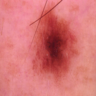

In [21]:
img

In [22]:
np.array(img)

array([[[228, 131, 133],
        [230, 130, 137],
        [231, 124, 133],
        ...,
        [235, 140, 147],
        [227, 133, 133],
        [225, 134, 133]],

       [[230, 132, 134],
        [229, 130, 133],
        [230, 126, 130],
        ...,
        [233, 140, 147],
        [230, 138, 140],
        [227, 138, 136]],

       [[229, 133, 134],
        [230, 130, 133],
        [229, 124, 129],
        ...,
        [235, 142, 151],
        [235, 143, 149],
        [231, 141, 139]],

       ...,

       [[211, 121, 125],
        [211, 121, 125],
        [210, 119, 123],
        ...,
        [219, 148, 136],
        [215, 144, 134],
        [211, 142, 129]],

       [[210, 120, 120],
        [210, 121, 122],
        [211, 123, 124],
        ...,
        [218, 147, 134],
        [215, 144, 134],
        [213, 142, 131]],

       [[209, 119, 121],
        [209, 118, 119],
        [211, 124, 125],
        ...,
        [218, 148, 135],
        [214, 144, 133],
        [211, 142, 128]]

In [23]:
from google.cloud import storage
from PIL import Image
import numpy as np
import io

def resize_image(image_name):
    client = storage.Client()
    bucket = client.bucket(BUCKET_NAME)
    
    # Construct full path to the image
    blob = bucket.blob(f"train_all_images/{image_name}.jpg")
    
    if blob.exists():  # Optional check
        image_bytes = blob.download_as_bytes()
        img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        img = img.resize((96, 96))
        return np.array(img)
    else:
        return None  # Or raise an error

In [24]:
X.head()

,passthrough__image_id,age__age,cat__sex_male,cat__localization_acral,cat__localization_back,cat__localization_chest,cat__localization_ear,cat__localization_face,cat__localization_foot,cat__localization_genital,cat__localization_hand,cat__localization_lower extremity,cat__localization_neck,cat__localization_scalp,cat__localization_trunk,cat__localization_upper extremity
0,ISIC_0031725,0.610163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0026876,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0030606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0028903,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0027954,0.058824,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X["np_array"] = X.passthrough__image_id.apply(resize_image)

In [28]:
X.iloc[2,-1].shape

(96, 96, 3)

In [29]:
X.head()

,passthrough__image_id,age__age,cat__sex_male,cat__localization_acral,cat__localization_back,cat__localization_chest,cat__localization_ear,cat__localization_face,cat__localization_foot,cat__localization_genital,cat__localization_hand,cat__localization_lower extremity,cat__localization_neck,cat__localization_scalp,cat__localization_trunk,cat__localization_upper extremity,np_array
0,ISIC_0031725,0.610163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[212, 100, 132], [215, 115, 137], [216, 126,..."
1,ISIC_0026876,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[210, 183, 188], [209, 182, 187], [208, 179,..."
2,ISIC_0030606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[159, 131, 135], [168, 139, 144], [176, 145,..."
3,ISIC_0028903,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[198, 174, 187], [200, 176, 189], [202, 180,..."
4,ISIC_0027954,0.058824,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[[[221, 145, 161], [219, 142, 157], [222, 143,..."


In [49]:
X.iloc[0:][0].shape

(96, 96, 3)

In [41]:
def get_cloud_image(name):
    for image in images:
        if image.endswith(f"{name}.jpg"):
            blob = bucket.blob(image)
            image_bytes = blob.download_as_bytes()
            img = Image.open(io.BytesIO(image_bytes))
            return img
    return None

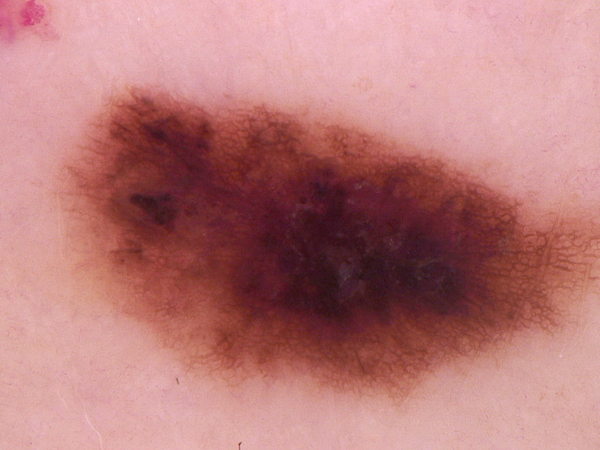

In [42]:
get_cloud_image("ISIC_0031725")

In [31]:
X = X.np_array

In [62]:
X.shape

(9771,)

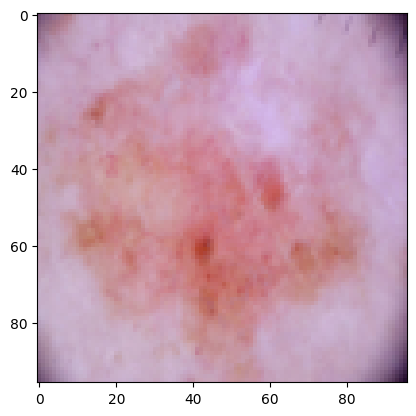

In [55]:
plt.imshow(X[10013])

In [56]:
y = np.array(y)

In [57]:
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [63]:
metadata[metadata.image_id == "

,lesion_id,image_id,dx,dx_type,age,sex,localization,index
0,HAM_0006706,ISIC_0031725,nv,histo,NaN,female,abdomen,8410
1,HAM_0002610,ISIC_0026876,vasc,consensus,0.0,female,abdomen,2388
2,HAM_0002610,ISIC_0030606,vasc,consensus,0.0,female,abdomen,2389
3,HAM_0003872,ISIC_0028903,nv,consensus,0.0,female,abdomen,9329
4,HAM_0002034,ISIC_0027954,bkl,consensus,5.0,male,abdomen,1035
...,...,...,...,...,...,...,...,...
10010,HAM_0005459,ISIC_0029610,akiec,histo,85.0,male,upper extremity,9840
10011,HAM_0005459,ISIC_0032397,akiec,histo,85.0,male,upper extremity,9865
10012,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,9875
10013,HAM_0000832,ISIC_0028763,akiec,histo,85.0,male,upper extremity,9950
